<h1>Problem 2</h1> 
<t>Build the model for rnn.LSTM and rnn.GRU for the tiny Shakespeare dataset. Train the models for the sequence of 20 and 30, report and compare training loss, validation accuracy, execution time for training, and computational and mode size complexities across the two models. 
Adjust the hyperparameters (fully connected network, number of hidden layers, and the number of hidden states) and compare your results (training and validation loss, computation complexity, model size, training and inference time, and the output sequence). Analyze their influence on accuracy, running time, and computational perplexity.</t>

<h2>Data Preprocessing</h2>

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import requests
import torch
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchinfo import summary
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h3>Load Text File:</h3>

In [5]:
textPath = "C:/Users/aidan_000/Desktop/UNCC/Github/Intro-to-DL/datasets/text-sequences/shakespeare.txt"

with open(textPath, "r") as file:
    text = file.read()

# Grab unique characters from the text
chars = sorted(list(set(text)))

# Create Dictionary to map each character to an unique int
idxTochar = {}
for i, char in enumerate(chars):
    idxTochar[i] = char

# Create Dictionary to map each int to a unique character
charToidx = {}
for i, char in enumerate(chars):
    charToidx[char] = i

encoded_text = [charToidx[char] for char in text]

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56, 1, 51, 43, 1, 57, 54, 43, 39, 49, 8, 0, 0, 13, 50, 50, 10, 0, 31, 54, 43, 39, 49, 6, 1, 57, 54, 43, 39, 49, 8, 0, 0, 18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 37, 53, 59]


<h3>Create Input Sequence and Dataset:</h3>

In [4]:
sequence_len = [20, 30, 50] # Input sequence length

k = 2 # 0, 1, choose input length

sequences, targets = [], []
for i in range(0, len(encoded_text) - sequence_len[k]):
    sequence = encoded_text[i: i+sequence_len[k]]
    target = encoded_text[i+sequence_len[k]]
    
    sequences.append(sequence)
    targets.append(target)

sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

class CharacterDataset(Dataset):
    def __init__(self, features, labels):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

dataset = CharacterDataset(sequences, targets)

batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Create DataLoaders for train and test sets
training_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

<h3>Model Training and Inferencing Function:</h3>

In [5]:
def train_model(model, criterion, optimizer, epochs, update_interval):
    
    training_losses = []
    validation_accuracies = []
    pbar_updateInterval = 0
    starting_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_train = time.time()
        
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            train_output = model(inputs)
            
            train_loss = criterion(train_output, labels)
            running_loss += train_loss.item()
            
            train_loss.backward()
            optimizer.step()

        training_loss = running_loss / len(training_loader)
        training_losses.append(training_loss)
        
        end_train = time.time()
        training_time = end_train - start_train

        model.eval()
        start_valid = time.time()

        with torch.no_grad():
            total_correct = 0
            total_samples = 0
            
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                valid_output = model(inputs)
                _, predicted = torch.max(valid_output, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)
        
            validation_accuracy = total_correct / total_samples * 100
            validation_accuracies.append(validation_accuracy)

        end_valid = time.time()
        validation_time = end_valid - start_valid

        if(epoch + 1) % update_interval == 0:
            with tqdm(total=epochs, desc=f'Epoch {epoch + 1}/{epochs}', bar_format='{l_bar}{bar}|{postfix}', dynamic_ncols=True) as pbar:
                pbar.update(epoch+1)
                pbar.set_postfix({'Training Loss ':' 'f'{training_losses[-1]:.4f}', 'Validation Accuracy':f'{validation_accuracies[-1]:.2f}%'})
        
    total_time = time.time() - starting_time

    print(f'\nTotal Duration: {total_time:.2f}s')
    print(f'Training Duration: {training_time:.2f}s')
    print(f'Inference Duration: {validation_time:.2f}s')

    print(f'\nFinal Training Loss: {training_losses[-1]:.4f}')
    print(f'Final Validation Accuracy: {validation_accuracies[-1]:.2f}%')
    
    return training_losses, validation_accuracies, training_time, validation_time


# Prediction function
def charInference(model, charToidx, idxTochar, initial_string):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([charToidx[c] for c in initial_string[-sequence_len[k]:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return idxTochar[predicted_index]

<h2>Next Character LSTM Model</h2>

<h3>Define LSTM Model:</h3>

In [6]:
class NextCharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NextCharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        return output

<h3>Hyperparameters and Training:</h3>

In [7]:
input_size = len(chars)
output_size = len(chars)
hidden_size = 128

lr = 0.001
epochs = 20
update_interval = 1

modelLSTM = NextCharLSTM(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelLSTM.parameters(), lr=lr)

LSTM_training_losses, LSTM_validation_accuracies, LSTM_training_time, LSTM_inference_time = train_model(modelLSTM, criterion, optimizer, epochs, update_interval)
torch.save(modelLSTM, 'ShakespeareLSTM')

Epoch 1/20:   0%|          |

Epoch 2/20:   0%|          |

Epoch 3/20:   0%|          |

Epoch 4/20:   0%|          |

Epoch 5/20:   0%|          |

Epoch 6/20:   0%|          |

Epoch 7/20:   0%|          |

Epoch 8/20:   0%|          |

Epoch 9/20:   0%|          |

Epoch 10/20:   0%|          |

Epoch 11/20:   0%|          |

Epoch 12/20:   0%|          |

Epoch 13/20:   0%|          |

Epoch 14/20:   0%|          |

Epoch 15/20:   0%|          |

Epoch 16/20:   0%|          |

Epoch 17/20:   0%|          |

Epoch 18/20:   0%|          |

Epoch 19/20:   0%|          |

Epoch 20/20:   0%|          |


Total Duration: 457.56s
Training Duration: 20.05s
Inference Duration: 2.73s

Final Training Loss: 1.3249
Final Validation Accuracy: 58.03%


<h3>Model Inferencing and Analysis</h3>

In [8]:
# modelLSTM = torch.load('ShakespeareLSTM')

# Predicting the next character
input_string = "They called me crazy and "
print(f"Original test string: {input_string}")
num_characters = 10

# Predict the next characters in a loop
for _ in range(num_characters):
    predicted_char = charInference(modelLSTM, charToidx, idxTochar, input_string)
    input_string += predicted_char
    
print(f"\nUpdated test string: {input_string}")

Original test string: They called me crazy and 

Updated test string: They called me crazy and her
To so 


<h2>Next Character GRU Model</h2>

<h3>Define GRU Model:</h3>

In [9]:
class NextCharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NextCharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.fc(output[:, -1, :])
        return output

<h3>Hyperparameters and Training:</h3>

In [10]:
input_size = len(chars) 
output_size = len(chars) 
hidden_size = 256

lr = 0.001
epochs = 20
update_interval = 1

modelGRU = NextCharGRU(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelGRU.parameters(), lr=lr)

GRU_training_losses, GRU_validation_accuracies, GRU_training_time, GRU_inference_time = train_model(modelGRU, criterion, optimizer, epochs, update_interval)
torch.save(modelGRU, 'ShakespeareGRU')

Epoch 1/20:   0%|          |

Epoch 2/20:   0%|          |

Epoch 3/20:   0%|          |

Epoch 4/20:   0%|          |

Epoch 5/20:   0%|          |

Epoch 6/20:   0%|          |

Epoch 7/20:   0%|          |

Epoch 8/20:   0%|          |

Epoch 9/20:   0%|          |

Epoch 10/20:   0%|          |

Epoch 11/20:   0%|          |

Epoch 12/20:   0%|          |

Epoch 13/20:   0%|          |

Epoch 14/20:   0%|          |

Epoch 15/20:   0%|          |

Epoch 16/20:   0%|          |

Epoch 17/20:   0%|          |

Epoch 18/20:   0%|          |

Epoch 19/20:   0%|          |

Epoch 20/20:   0%|          |


Total Duration: 540.88s
Training Duration: 24.06s
Inference Duration: 3.02s

Final Training Loss: 1.3692
Final Validation Accuracy: 56.95%


<h3>Model Inferencing and Analysis</h3>

In [11]:
# modelGRU = torch.load('ShakespeareGRU')

# Predicting the next character
input_string = "They called me crazy and "
print(f"Original test string: {input_string}")
num_characters = 10

# Predict the next characters in a loop
for _ in range(num_characters):
    predicted_char = charInference(modelLSTM, charToidx, idxTochar, input_string)
    input_string += predicted_char
    
print(f"\nUpdated test string: {input_string}")

Original test string: They called me crazy and 

Updated test string: They called me crazy and her
To so 


<h2>Comparing Model Training Experiences</h2>

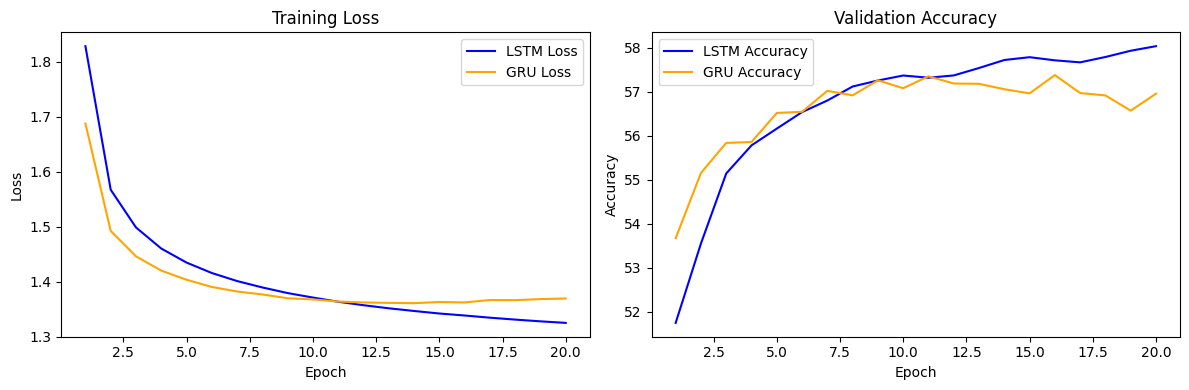

In [12]:
epochs_range = range(1, epochs + 1)
# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, LSTM_training_losses, label='LSTM Loss', color = 'blue')
plt.plot(epochs_range, GRU_training_losses, label='GRU Loss', color = 'orange')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, LSTM_validation_accuracies, label='LSTM Accuracy', color = 'blue')
plt.plot(epochs_range, GRU_validation_accuracies, label='GRU Accuracy', color = 'orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
LSTM_stats = summary(modelLSTM, (sequence_len[k], input_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
print()
GRU_stats = summary(modelGRU, (sequence_len[k], input_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])

print(f'\n========================================= Total Time per Model =========================================')
print(f'LSTM Training Duration: {LSTM_training_time:.2f}s, LSTM Inference Duration: {LSTM_inference_time:.2f}s')
print(f'GRU  Training Duration: {GRU_training_time:.2f}s,  GRU Inference Duration: {GRU_inference_time:.2f}s')
print(f'========================================================================================================')

print(f'\n========================================= Accuracies per Model =========================================')
print(f'LSTM Training Loss: {LSTM_training_losses[-1]:.4f}, LSTM Inference Accuracy: {LSTM_validation_accuracies[-1]:.2f}%')
print(f'GRU  Training Loss: {GRU_training_losses[-1]:.4f},  GRU Inference Accuracy: {GRU_validation_accuracies[-1]:.2f}%')
print(f'========================================================================================================')

Layer (type (var_name))                  Kernel Shape     Output Shape     Param #          Mult-Adds
NextCharLSTM (NextCharLSTM)              --               [50, 65]         --               --
├─Embedding (embedding)                  --               [50, 65, 128]    8,320            416,000
│    └─weight                            [128, 65]                         └─8,320
├─LSTM (lstm)                            --               [50, 65, 128]    132,096          429,312,000
│    └─weight_ih_l0                      [512, 128]                        ├─65,536
│    └─weight_hh_l0                      [512, 128]                        ├─65,536
│    └─bias_ih_l0                        [512]                             ├─512
│    └─bias_hh_l0                        [512]                             └─512
├─Linear (fc)                            --               [50, 65]         8,385            419,250
│    └─weight                            [128, 65]                         ├─8,320
│  